<a href="https://colab.research.google.com/github/Kondwani7/English-to-French-Translator/blob/main/English_to_French_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [2]:
import collections
from collections import Counter

import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

import plotly.express as px
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

from tabulate import tabulate

import gc


In [3]:
data = pd.read_csv('/content/drive/MyDrive/practice datasets/eng_-french_translation/eng_-french.csv')

#Data investigation

In [4]:
print("Total records: ", data.shape[0])

Total records:  175621


In [5]:
data.describe()

,English words/sentences,French words/sentences
count,175621,175621
unique,123100,165975
top,I can't tell you how happy I am that you've co...,C'est bizarre.
freq,32,9


In [6]:
data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [7]:
data = data.rename(columns={"English words/sentences":"English", "French words/sentences":"French" })

In [8]:
def word_count(txt):
  return len(txt.split())

In [9]:
#word count
data['English_Count'] = data['English'].apply(lambda x: word_count(x))
data['French_Count'] = data['French'].apply(lambda x: word_count(x))

In [10]:
data.head()

,English,French,English_Count,French_Count
0,Hi.,Salut!,1,1
1,Run!,Cours !,1,2
2,Run!,Courez !,1,2
3,Who?,Qui ?,1,2
4,Wow!,Ça alors !,1,3


In [11]:
print('{} Englsh Words'.format(data['English_Count'].sum()))
print('{} French Words'.format(data['French_Count'].sum()) )


1082098 Englsh Words
1177832 French Words


In [12]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("English", "French"))

fig.add_trace( go.Histogram(x=data['English_Count'], histfunc='sum', opacity=0.8, showlegend=False, text='English'), row=1, col=1)
fig.add_trace( go.Histogram(x=data['French_Count'], histfunc='sum', opacity=.8, showlegend=False, text='French'), row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Words Distribution")
fig.show()




#Data Preprocessing

In [13]:
#Tokenization function
def tokenize(x):
  x_tk = Tokenizer(char_level = False)
  x_tk.fit_on_texts(x)
  return x_tk.texts_to_sequences(x), x_tk



In [14]:
#Padding: reshaping inputs to the same size to reduce training time
def pad(x, length=None):
  if length is None:
    length = max([len(sentence) for sentence in x])
  return pad_sequences(x, maxlen = length, padding='post')



In [15]:
#tokenize the english text and determine the vocab size
eng_seq, eng_tok = tokenize(data['English'])
eng_vocab_size = len(eng_tok.word_index) + 1
print("Complete English Vocab Size: ", eng_vocab_size)
#french tokenization and vocab size
frn_seq, frn_tok = tokenize(data['French'])
frn_vocab_size = len(frn_tok.word_index) + 1
print("Complete French Vocab Size:", frn_vocab_size)


Complete English Vocab Size:  14532
Complete French Vocab Size: 30661


In [16]:
#sequence length
eng_len = max([len(sentence) for sentence in eng_seq])
frn_len = max([len(sentence) for sentence in frn_seq])
print("English Sequence Length: ", eng_len, "\n",
      "French Sequence length: ", frn_len)



English Sequence Length:  44 
 French Sequence length:  55


In [17]:
# data split
train_data, test_data = train_test_split(data, test_size=.25, random_state = 8)


In [18]:
#Drop Columns
train_data = train_data.drop(columns=['English_Count', 'French_Count'], axis=1)
test_data = test_data.drop(columns =['English_Count', 'French_Count'], axis=1)
#Re-index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)



In [19]:
print("Train shape",train_data.shape[0])
print("Test shape", test_data.shape[0])

Train shape 131715
Test shape 43906


In [20]:
# -- Tokenization --
# Training Data
train_X_seq, train_X_tok = tokenize(train_data['English'])
train_Y_seq, train_Y_tok = tokenize(train_data['French'])

train_eng_vocab = len(train_X_tok.word_index) + 1
train_frn_vocab = len(train_Y_tok.word_index) + 1

#Testing data
test_X_seq, test_X_tok = tokenize(test_data["English"])
test_Y_seq, test_Y_tok = tokenize(test_data['French'])

test_eng_vocab = len(test_X_tok.word_index) + 1
test_frn_vocab = len(test_Y_tok.word_index) + 1

#padding
#train data
train_X_seq = pad(train_X_seq)
train_Y_seq = pad(train_Y_seq)
#test data
test_X_seq = pad(test_X_seq)
test_Y_seq = pad(test_Y_seq)



In [21]:
#tabulate the vocab size
tab_data = [["Train", train_eng_vocab, train_frn_vocab], ["Test", test_eng_vocab, test_frn_vocab]]
print(tabulate(tab_data, headers=['Dataset', 'Eng Vocab Size', 'Frn Vocab Size'], tablefmt='pretty'))

+---------+----------------+----------------+
| Dataset | Eng Vocab Size | Frn Vocab Size |
+---------+----------------+----------------+
|  Train  |     13204      |     27214      |
|  Test   |      8979      |     16768      |
+---------+----------------+----------------+


#Model Building

In [22]:
#lstm model
def cust_model(in_vocab, out_vocab, in_timesteps, out_timesteps, btch_size):
  model = Sequential()
  model.add(Embedding(in_vocab, btch_size, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(btch_size))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(btch_size, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))

  return model



In [23]:
#compile the model
batch_size = 64
lr = 1e-3
#model
model = cust_model(eng_vocab_size, frn_vocab_size, eng_len, frn_len, batch_size)

#Compile Model
model.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr))

In [25]:
fn = 'model.h1.MT'
epoch = 2
val_split = 0.1

#Checkpoint
checkpoint = ModelCheckpoint(fn, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#Train
history = model.fit(train_X_seq, train_Y_seq,
                    epochs=epoch, batch_size=batch_size, validation_split = val_split, callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/2
1853/1853 [==============================] - ETA: 0s - loss: 0.7678
Epoch 00001: val_loss improved from inf to 0.75718, saving model to model.h1.MT


INFO:tensorflow:Assets written to: model.h1.MT/assets


INFO:tensorflow:Assets written to: model.h1.MT/assets


1853/1853 [==============================] - 4033s 2s/step - loss: 0.7678 - val_loss: 0.7572
Epoch 2/2
1853/1853 [==============================] - ETA: 0s - loss: 0.7245
Epoch 00002: val_loss improved from 0.75718 to 0.71535, saving model to model.h1.MT


INFO:tensorflow:Assets written to: model.h1.MT/assets


INFO:tensorflow:Assets written to: model.h1.MT/assets


1853/1853 [==============================] - 4027s 2s/step - loss: 0.7245 - val_loss: 0.7153


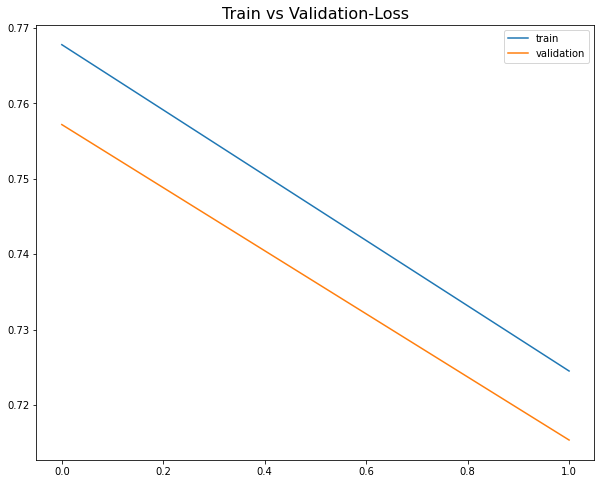

In [30]:
#plot the model's performance
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.title('Train vs Validation-Loss', fontsize=16)
plt.show()

